# **Question 1** 

In [1]:
# Import Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

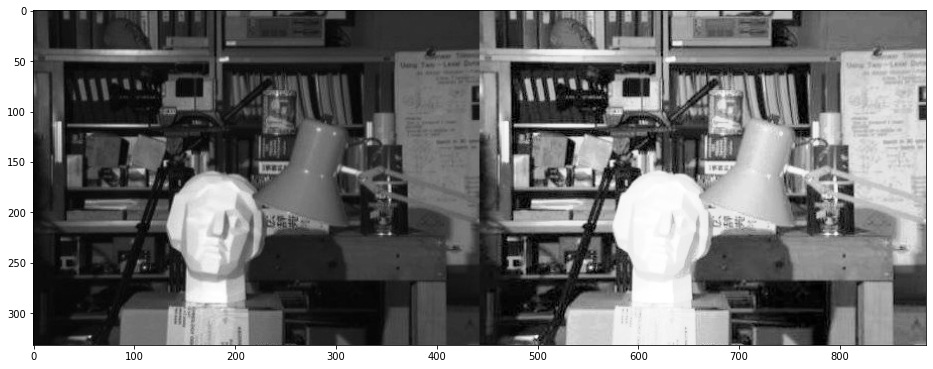

In [2]:
########### Histogram Equalization ##########

# Read image
img = cv2.imread('image1.jpg', 0)

# import Histogram Equalization from OpenCV Library
equ = cv2.equalizeHist(img)

#Stacking images side-by-side
res = np.hstack((img, equ)) 

#plot figures
plt.figure(figsize=(16, 16))
plt.imshow(res, cmap='gray')

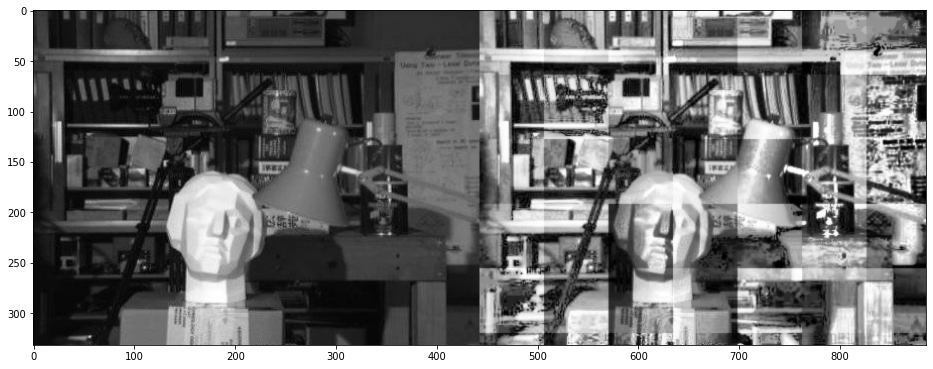

In [3]:
########### Adaptive Histogram Equalization - Grid Image ##########

def adaptive_hist_equ(image, window_size=64, clip_limit=None):
    '''
    Implement Adaptive Histogram Equalization
    
    Args:
        image (ndarray): Input image (grayscale)
        window_size (int): Size of local region (should be power of 2)
        clip_limit (float): Contrast limit for preventing over-amplification of noise
                          (if None, no clipping is applied)
    
    Returns:
        output_image (ndarray): Enhanced image
    '''
    # Input validation
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale")
    
    # Create output image
    output_image = np.zeros_like(image, dtype=np.float64)
    rows, cols = image.shape
    
    # Calculate number of regions
    row_regions = int(np.ceil(rows / window_size))
    col_regions = int(np.ceil(cols / window_size))
    
    # Process each region
    for i in range(row_regions):
        for j in range(col_regions):
            # Define region boundaries
            row_start = i * window_size
            row_end = min(row_start + window_size, rows)
            col_start = j * window_size
            col_end = min(col_start + window_size, cols)
            
            # Extract region
            region = image[row_start:row_end, col_start:col_end]
            
            # Calculate histogram for region
            hist = np.histogram(region.flatten(), bins=256, range=(0, 255))[0]
            
            # Apply clipping if specified
            if clip_limit is not None:
                clip_value = (region.size * clip_limit / 256)
                hist = np.clip(hist, 0, clip_value)
                
                # Redistribute clipped pixels
                clipped_pixels = hist[hist > clip_value].sum() - clip_value * (hist > clip_value).sum()
                hist[hist > clip_value] = clip_value
                redistrib_count = clipped_pixels / 256
                hist += redistrib_count
            
            # Calculate CDF for region
            cumsum = np.cumsum(hist)
            # Normalize CDF
            if cumsum[-1] != 0:  # Avoid division by zero
                cdf = np.floor(255 * (cumsum / cumsum[-1]))
            else:
                cdf = np.zeros(256)
            
            # Apply transformation to region
            region_output = np.zeros_like(region, dtype=np.float64)
            for k in range(256):
                region_output[region == k] = cdf[k]
            
            # Store in output image
            output_image[row_start:row_end, col_start:col_end] = region_output
    
    # Bilinear interpolation between regions to reduce boundary artifacts
    if window_size > 1:
        from scipy.ndimage import gaussian_filter
        output_image = gaussian_filter(output_image, sigma=0.5)
    
    return output_image.astype(np.uint8)


# Read image
img = cv2.imread('image1.jpg', 0)


equ = adaptive_hist_equ(img)

#stacking images side-by-side
res = np.hstack((img, equ)) 

#plot figures
plt.figure(figsize=(16, 16))
plt.imshow(res, cmap='gray')


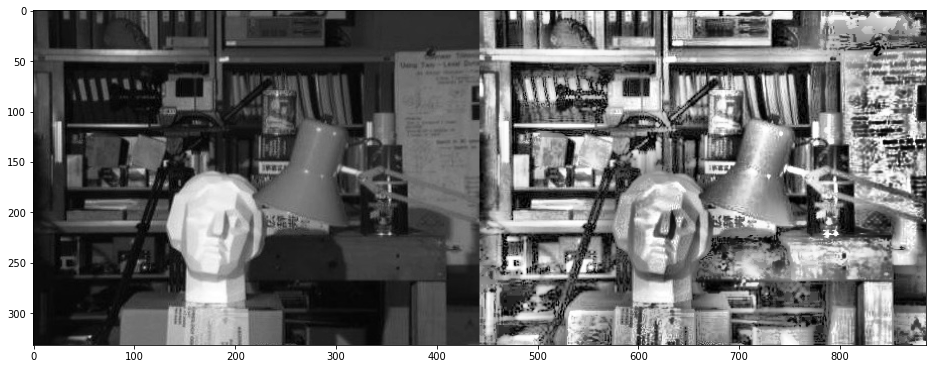

In [4]:
########### Adaptive Histogram Equalization - pixel wise ##########

def optimized_pixel_wise_ahe(image, window_radius=32, clip_limit=None):
    '''
    Optimized version using convolution-based approach for faster processing
    with fixed dimension handling
    
    Args:
        image (ndarray): Input image (grayscale)
        window_radius (int): Radius of the neighborhood window
        clip_limit (float): Contrast limit to prevent noise amplification
    
    Returns:
        output_image (ndarray): Enhanced image
    '''
    from scipy.ndimage import uniform_filter
    
    if len(image.shape) != 2:
        raise ValueError("Input image must be grayscale")
    
    # Convert image to float32 for processing
    image = image.astype(np.float32)
    rows, cols = image.shape
    window_size = 2 * window_radius + 1
    
    # Create a single 3D array for all intensity values
    hist_3d = np.zeros((256, rows, cols), dtype=np.float32)
    
    # Fill the 3D array with binary masks for each intensity
    for i in range(256):
        hist_3d[i] = (image == i).astype(np.float32)
        # Apply uniform filter to each slice
        hist_3d[i] = uniform_filter(hist_3d[i], size=window_size, mode='reflect')
    
    # Transpose to get shape (rows, cols, 256)
    hist_accum = np.transpose(hist_3d, (1, 2, 0))
    
    # Apply clipping if specified
    if clip_limit is not None:
        window_area = window_size ** 2
        clip_value = window_area * clip_limit / 256
        hist_accum = np.clip(hist_accum, 0, clip_value)
        
        # Redistribute clipped pixels
        clipped_sum = np.sum(np.maximum(hist_accum - clip_value, 0), axis=2, keepdims=True)
        redistrib_count = clipped_sum / 256
        hist_accum = np.minimum(hist_accum, clip_value) + redistrib_count
    
    # Calculate CDF for each pixel
    cdf_accum = np.cumsum(hist_accum, axis=2)
    
    # Normalize CDF
    # Add small epsilon to avoid division by zero
    denominator = cdf_accum[:,:,-1][:,:,np.newaxis] + 1e-8
    cdf_norm = cdf_accum * 255.0 / denominator
    
    # Create output image
    output_image = np.zeros_like(image)
    for i in range(256):
        mask = (image == i)
        output_image[mask] = cdf_norm[mask, i]
    
    return np.clip(output_image, 0, 255).astype(np.uint8)


# Read image
img = cv2.imread('image1.jpg', 0)

equ = optimized_pixel_wise_ahe(img, window_radius=32, clip_limit=0.03) #stacking images side-by-side

#stacking images side-by-side
res = np.hstack((img, equ))

#plot figures
plt.figure(figsize=(16, 16))
plt.imshow(res, cmap='gray')

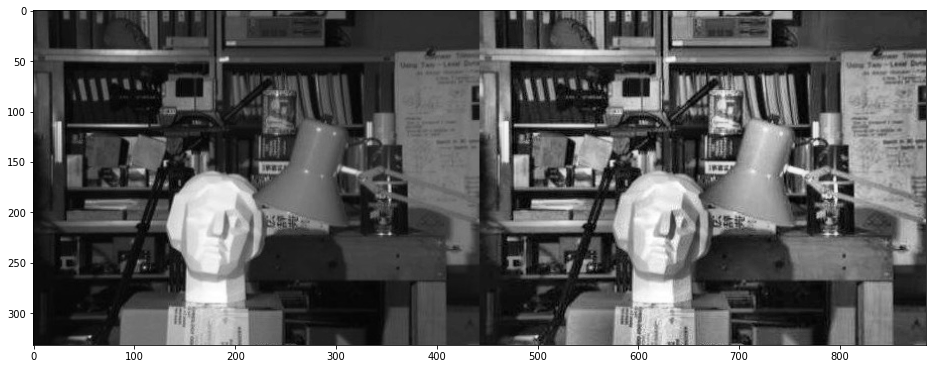

In [5]:
########### CLAHE ##########

# Read image
img = cv2.imread('image1.jpg', 0)

# import CLAHE algorithm from CV2 
clahe = cv2.createCLAHE(clipLimit=2.0)
clh = clahe.apply(img)


#Stacking images side-by-side
res = np.hstack((img, clh)) 

#plot figures
plt.figure(figsize=(16, 16))
plt.imshow(res, cmap='gray')